In [11]:
#from nilearn import plotting
#from nilearn.input_data import NiftiMasker
#from nilearn.datasets import load_mni152_brain_mask
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
import xgboost as xgb
import regression_common
import joblib
import matplotlib.pyplot as plt

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

data_dir='../../data/'

In [3]:
from google.colab import drive
data_dir='drive/My Drive/colab/'
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Create/store/load binary image data
if not os.path.isfile(data_dir + 'binary_imgs.npy'):

    dataset_path = "../sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
    img_filenames = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
    img_filenames.sort()
    print('Number of subjects: %d' % len(img_filenames))

    img_shape = load_img(img_filenames[0]).shape

    mask_img = load_mni152_brain_mask()
    masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache', verbose=5)
    masker = masker.fit()

    imgs = masker.transform(img_filenames) # break down into slices if necessary
    imgs = imgs.astype(bool)
    np.save(data_dir + 'binary_imgs', imgs)

else:
    imgs = np.load(data_dir + 'binary_imgs.npy')

print(imgs.shape)

(1401, 228453)


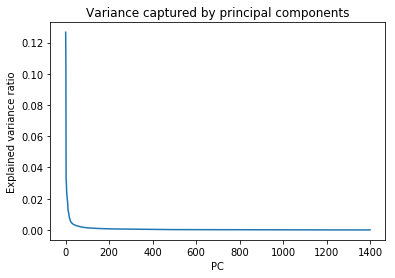

In [0]:
# plot variance explained by components
if not os.path.isfile('../data/pca_all.joblib'): 
    pca_all = PCA(copy=False)
    X_pc_all = pca_all.fit_transform(imgs)
    #np.save('../data/binary_imgs_pc_all.npy', X_pc_all)
    joblib.dump(pca_all, '../data/pca_all.joblib')

else:
    pca_all = joblib.load('../data/pca_all.joblib')
    
plt.plot(pca_all.explained_variance_ratio_)
plt.title("Variance captured by principal components")
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.show()

### Single-output Regression analysis with 100 PC components, repreat on every fold

In [3]:
X = imgs
patient_df = pd.read_hdf(data_dir + 'patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))

### Ridge

In [4]:
def perform_ridge(X, Y):
    print('Performing Ridge regression (5-fold nested CV) on each domain')
    estimator = MultiOutputRegressor(Ridge())
    #alpha = np.linspace(0, 10, 51)
    alpha = np.linspace(20000, 80000, 501)
    my_grid={"estimator__alpha": alpha}
    return regression_common.perform_regression(X, Y, estimator, my_grid, pca_fold=True)

In [5]:
scores_mr = perform_ridge(X, Y)

Performing Ridge regression (5-fold nested CV) on each domain

Fold-1: Best params: {'estimator__alpha': 70520.0}

Fold-2: Best params: {'estimator__alpha': 42320.0}

Fold-3: Best params: {'estimator__alpha': 38240.0}

Fold-4: Best params: {'estimator__alpha': 29480.0}

Fold-5: Best params: {'estimator__alpha': 51080.0}


### SVR

In [14]:
def perform_svr_rbf(X, Y):
    print('Performing SVR regression (5-fold nested CV) on each domain')
    estimator = MultiOutputRegressor(SVR(kernel='rbf'))
    my_grid={"estimator__C": [1e-1, 1e0, 1e1, 1e2, 1e3], "estimator__gamma": np.logspace(-1, 8, 10)}
    return regression_common.perform_regression(X, Y, estimator, my_grid, pca_fold=True)

In [15]:
scores_svr = perform_svr_rbf(X, Y)

Performing SVR regression (5-fold nested CV) on each domain

Fold-1: Best params: {'estimator__C': 1.0, 'estimator__gamma': 100.0}

Fold-2: Best params: {'estimator__C': 10.0, 'estimator__gamma': 100000.0}

Fold-3: Best params: {'estimator__C': 10.0, 'estimator__gamma': 10000.0}

Fold-4: Best params: {'estimator__C': 10.0, 'estimator__gamma': 10000.0}

Fold-5: Best params: {'estimator__C': 1.0, 'estimator__gamma': 100.0}


### Random Forest

In [ ]:
def perform_random_forest_regr(X, Y):
    print('Performing Random Forest regression (5-fold nested CV) on each domain')
    estimator = MultiOutputRegressor(RandomForestRegressor(random_state=39))

    n_estimators = [10, 100, 500, 1000]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [10, 50, 100, None]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    max_samples = [0.4, 0.5, 0.7, 0.8]
    
    my_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__max_samples': max_samples}
    
    return regression_common.perform_regression(X, Y, estimator, my_grid, random_search_cv=True, pca_fold=True)

In [ ]:
scores_rf = perform_random_forest_regr(X, Y)

Performing Random Forest regression (5-fold nested CV) on each domain

Fold-1: Best params: {'estimator__n_estimators': 1000, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_samples': 0.8, 'estimator__max_features': 'log2', 'estimator__max_depth': 10}

Fold-2: Best params: {'estimator__n_estimators': 1000, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_samples': 0.8, 'estimator__max_features': 'log2', 'estimator__max_depth': 10}

Fold-3: Best params: {'estimator__n_estimators': 1000, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_samples': 0.8, 'estimator__max_features': 'log2', 'estimator__max_depth': 10}

Fold-4: Best params: {'estimator__n_estimators': 1000, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_samples': 0.8, 'estimator__max_features': 'log2', 'estimator__max_depth': 10}


### Neural Net

In [ ]:
# For fun
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

def get_nn_model():
    model = Sequential()
    model.add(Dense(25, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation=None))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def perform_nn_regr(X, Y):
    print('Performing Neural Network regression (5-fold nested CV)')
    estimator = MultiOutputRegressor(KerasRegressor(build_fn=get_nn_model, epochs=3, batch_size=4, verbose=0))
    return regression_common.perform_regression(X, Y, estimator, {}, pca_fold=True)

In [ ]:
scores_nn = perform_nn_regr(X, Y)

In [ ]:
# to plot results

scores_all_models = pd.DataFrame()

scores_ridge.insert(0, "Model", "Ridge")
scores_svr.insert(0, "Model", "SVR")
scores_rf.insert(0, "Model", "Random Forest")
#scores_xgb.insert(0, "Model", "XGBoost")
scores_nn.insert(0, "Model", "Neural Network")

scores_all_models = pd.concat([scores_ridge, scores_svr, scores_rf, scores_nn], ignore_index=True)
# scores_all_models = pd.concat([scores_ridge, scores_svr, scores_rf, scores_xgb, scores_nn], ignore_index=True)

In [ ]:
# persist results
scores_all_models.to_hdf(data_dir + 'results_pca_100_inside_cv_single_output.h5', key='p', mode='w')
#scores_all_models = pd.read_hdf(data_dir + 'results_pca_100_inside_cv_single_output.h5', key='p', mode='r')

In [ ]:
# Plot results
regression_common.plot_all_scores(scores_all_models)

In [0]:
// doing